## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'

### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [8]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Compare ML performance 

In [13]:
qc_type = 'gleb' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']
model_type = 'regression'

ml_perf_concat_DX = pd.DataFrame()
for dx_grp in [0,1]:
    
    if model_type.lower() == 'regression':
        outcome_col = 'AGE_AT_SCAN'
        covar_continuous_cols = []
        covar_cat_cols = ['SEX','SITE_ID','DX_GROUP']

        model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
    else: 
        outcome_col = 'DX_GROUP'
        covar_continuous_cols = ['AGE_AT_SCAN']
        covar_cat_cols = ['SEX','SITE_ID']

        #model = svm.SVC(kernel='linear')
        model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

    ml_perf_concat = pd.DataFrame()
    perf_pval_dict = {}
    start_time_ML = time.time()
    for atlas in data_dict.keys():
        start_time_atlas = time.time()
        print('Atlas {}'.format(atlas))
        master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)

        #------------------- Need to move this to a def-----------------------------
        if qc_type in ['maarten','gleb']:
            qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
            master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
            # This generate NaNs since qc_df doesn't have all subjects in the master_df
            # Current implementation will discard these NaN subjects if QC is used 
            if qc_type == 'maarten':
                master_df = master_df[master_df['QC_maarten']==0]    
            elif qc_type == 'gleb':
                master_df = master_df[master_df['QC_gleb'].isin(['1','-+1'])]
            else:
                print('unknown qc_type')

            print('Filtering based on {} QC. Resultant number of subjects {})'.format(qc_type,len(master_df[subject_ID_col].unique())))
            common_subs = master_df[subject_ID_col].unique()
        else:
            master_df = master_df_raw
            print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))

        # Check for minimum sample size requirement for covariates, especially SITE_ID
        print('\nPerforming min sample size check')
        covars_to_check = ['SITE_ID']
        min_count = 4 #at least 4 subject per site (per atlas)
        for covar in covars_to_check:
            counts = master_df[covar].value_counts()
            master_df = master_df[master_df[covar].isin(counts[counts > min_count].index)]
            print("Dropping {} {}".format(covar,counts[counts <= min_count]))

        print('Resultant number of subjects {} ({})'.format(qc_type,len(master_df[subject_ID_col].unique())))
        common_subs = master_df[subject_ID_col].unique()

        #------------------- Need to move this to a def-----------------------------

        # Compute Dx based performance separately for now
        # Since using scikit learn defined cross-val-score
        ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
        
        roi_cols = master_df.filter(regex='^L|R_', axis=1).columns
        #master_df['pipeline'] = np.tile(atlas,len(master_df))
        ml_perf, null_df, pvalue = getMLModelPerf(ml_master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)
        ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
        null_df['atlas'] = np.tile('null',len(null_df))
        ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
        perf_pval_dict[atlas] = pvalue
        print('time to process atlas {:4.3f}s \n'.format(time.time()-start_time_atlas))

    # Need to append Dx based performance separately for now
    # Since using scikit learn defined cross-val-score
    ml_perf_concat['DX_GROUP'] = np.tile(dx_grp,len(ml_perf_concat))
    ml_perf_concat_DX = ml_perf_concat_DX.append(ml_perf_concat)

print('time to process ML {:4.3}s'.format(time.time()-start_time_ML))


Atlas Destrieux
Filtering based on gleb QC. Resultant number of subjects 240)

Performing min sample size check
Dropping SITE_ID OLIN       4
OHSU       3
UCLA_2     3
MAX_MUN    3
PITT       2
Name: SITE_ID, dtype: int64
Resultant number of subjects gleb (225)
Using 3 col for 12 cat covar
Data shapes X (132, 160), y 132 (14.99m, 5.52sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-14.346, sd:5.982
time to process atlas 16.402s 

Atlas aparc
Filtering based on gleb QC. Resultant number of subjects 240)

Performing min sample size check
Dropping SITE_ID OLIN       4
OHSU       3
UCLA_2     3
MAX_MUN    3
PITT       2
Name: SITE_ID, dtype: int64
Resultant number of subjects gleb (225)
Using 3 col for 12 cat covar
Data shapes X (132, 80), y 132 (14.99m, 5.52sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-15.811, sd:6.333
time to process atlas 13.486s 

Atlas Glasser
Filtering based on gleb QC. Resultant number of subjects 240)



{'Destrieux': 0.09090909090909091, 'aparc': 0.09090909090909091, 'Glasser': 0.09090909090909091}


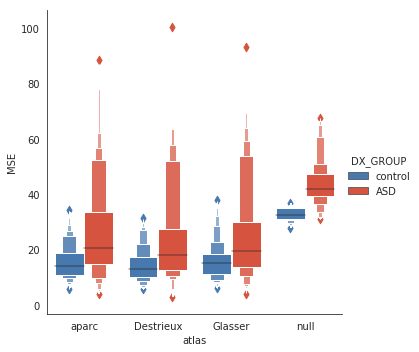

In [14]:
print(perf_pval_dict)
ml_perf_concat_DX['MSE'] = -1*ml_perf_concat_DX['neg_mean_squared_error']
x_order = ['aparc','Destrieux','Glasser','null']
ml_perf_concat_DX['DX_GROUP'] = ml_perf_concat_DX['DX_GROUP'].replace({0:'control', 1:'ASD'})
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple"]
with sns.axes_style("white"): 
    g = sns.catplot(y='MSE',x='atlas',kind='boxen',hue='DX_GROUP',data=ml_perf_concat_DX, 
                    order=x_order, palette=sns.xkcd_palette(colors))
    #g.set(ylim=(0, 80))


### Compare statsmodels performance 

In [8]:
covar_continuous_cols = ['AGE_AT_SCAN']
covar_cat_cols = ['SEX','SITE_ID']
outcome_col = 'DX_GROUP' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #ols #logit
stat_perf_dict = {}
save_sm_perf = True
qc_type = 'gleb'

for atlas in data_dict.keys():
    mr_data_df = data_dict[atlas]
    roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
    master_df_raw = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)
    
   #------------------- Need to move this to a def-----------------------------
    if qc_type in ['maarten','gleb']:
        qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
        master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
        # This generate NaNs since qc_df doesn't have all subjects in the master_df
        # Current implementation will discard these NaN subjects if QC is used 
        if qc_type == 'maarten':
            master_df = master_df[master_df['QC_maarten']==0]    
        elif qc_type == 'gleb':
            master_df = master_df[master_df['QC_gleb'].isin(['1','-+1'])]
        else:
            print('unknown qc_type')

        print('Filtering based on {} QC. Resultant number of subjects {})'.format(qc_type,len(master_df[subject_ID_col].unique())))
        common_subs = master_df[subject_ID_col].unique()
    else:
        master_df = master_df_raw
        print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))

    # Check for minimum sample size requirement for covariates, especially SITE_ID
    print('\nPerforming min sample size check')
    covars_to_check = ['SITE_ID']
    min_count = 4 #at least 3 subject per site (per pipeline)
    for covar in covars_to_check:
        counts = master_df[covar].value_counts()
        master_df = master_df[master_df[covar].isin(counts[counts > min_count].index)]
        print("Dropping {} {}".format(covar,counts[counts <= min_count]))

    print('Resultant number of subjects {} ({})'.format(qc_type,len(master_df[subject_ID_col].unique())))
    common_subs = master_df[subject_ID_col].unique()
    
    #------------------- Need to move this to a def-----------------------------
    
    master_df['atlas'] = np.tile(atlas,len(master_df))
    
    #Save standarized df to csv for outlier detection
    #master_df.to_csv(fs60_dir + '{}_standarized.csv'.format(atlas))
    
    sm_perf = getStatModelPerf(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    print('Top 10 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(10)))
    print('')
    
if save_sm_perf:
    save_path = '{}atlas_sm_perf_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col,qc_type,len(common_subs))
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    with open(save_path, 'wb') as handle:
        pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Filtering based on gleb QC. Resultant number of subjects 240)

Performing min sample size check
Dropping SITE_ID OLIN       4
UCLA_2     3
MAX_MUN    3
OHSU       3
PITT       2
Name: SITE_ID, dtype: int64
Resultant number of subjects gleb (225)
Example statsmodel run:
 DX_GROUP ~ R_S_temporal_transverse + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (148, 5)
Top 10 significant regions:
                              roi      coef     t_val     p_val  p_val_corr
79          R_G_and_S_cingul_Ant -3.404285 -3.200668  0.001371    0.139621
41              L_Pole_occipital -3.127741 -3.107501  0.001887    0.139621
69                L_S_suborbital -1.671961 -2.862066  0.004209    0.207639
74        R_G_and_S_frontomargin -1.951481 -2.536507  0.011196    0.329550
134  R_S_oc_temp_med_and_Lingual -2.841190 -2.464394  0.013725    0.329550
47       L_S_circular_insula_inf -2.135008 -2.391570  0.016776    0.329550
5           L_G_and_S_cingul_Ant -2.304067 -2.384807  0.01

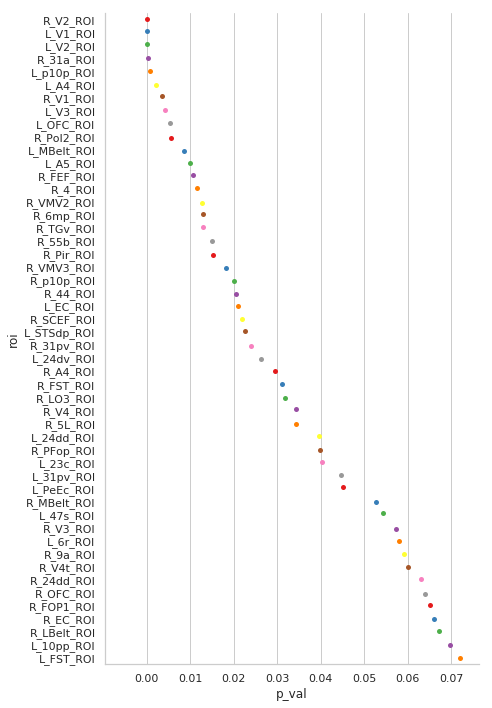

In [9]:
# Plots
aparc = 'Glasser' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");

In [15]:
master_df['DX_GROUP'].value_counts()

1    132
0     93
Name: DX_GROUP, dtype: int64